In [114]:
import json
import pandas as pd
import io
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime, timedelta
from pytz import timezone
import pytz

In [115]:
# Declare currency
currency = "bitcoin"
symbol = "BTC"

# Define paths of data from twitter and crypto values
folder_crypto = f"../data/crypto/{symbol}"
folder_twitter = f"../data/twitter/{symbol}"

In [116]:
# Get files from the twitter folder
twitter_files = glob.glob(f"{folder_twitter}/*~*.csv")
twitter_files = sorted(twitter_files)

# Create dataframe for all tweets
dfs = []
for file in twitter_files:
    dfs.append(pd.read_csv(file))
tweets = pd.concat(dfs)

# Remove same tweets
print('Shape before removing same tweets', tweets.shape)

duplicates_removed = tweets.shape[0]
tweets = tweets.drop_duplicates(subset=['ID'])
duplicates_removed -= tweets.shape[0]

print('Shape after removing samee tweets: ', tweets.shape)
print('Number of tweets removed: ', duplicates_removed)

tweets.head(2)

Shape before removing same tweets (1884126, 9)
Shape after removing samee tweets:  (1861016, 9)
Number of tweets removed:  23110


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,score
0,1477990572501737472,RT : Have you ever seen a project like $SOUL g...,Tah,92,41,0,Mon Jan 03 13:09:46 +0000 2022,0.3612,33.5916
2,1477990578650497024,"RT : $20,000 BTC and $20,000 ETH for 10 Lucky ...",Saarou,27,619,0,Mon Jan 03 13:09:48 +0000 2022,0.6486,18.1608


In [117]:
# Get files from the crypto folder
crypto_files = glob.glob(f"{folder_crypto}/*.csv")
dfs = []

# Create dataframe for all prices
for file in crypto_files:
    dfs.append(pd.read_csv(file))
crypto_usd = pd.concat(dfs)
crypto_usd = crypto_usd.sort_values(by=['time'])

# Remove same values
print('Shape before removing same prices: ', crypto_usd.shape)

duplicates_removed = crypto_usd.shape[0]
crypto_usd = crypto_usd.drop_duplicates(subset=['time'])
duplicates_removed -= crypto_usd.shape[0]

print('Shape after removing same prices: ', crypto_usd.shape)
print('Number of values removed: ', duplicates_removed)

crypto_usd.head(2)

Shape before removing same prices:  (12476, 7)
Shape after removing same prices:  (12466, 7)
Number of values removed:  10


,time,high,low,open,close,conversionType,conversionSymbol
0,1641260820,46135.85,46112.31,46129.55,46112.54,direct,NaN
1,1641260880,46116.30,46052.92,46112.54,46054.34,direct,NaN


In [118]:
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'])
tweets.index = tweets['CreatedAt']

tweets_grouped = tweets.groupby(pd.Grouper(freq="2H"))['score'].sum()

crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='s', utc=True)
crypto_usd.index = crypto_usd['time']

crypto_usd_grouped = crypto_usd.groupby(pd.Grouper(freq="2H"))['close'].mean()

In [119]:
tweets_grouped.head()

CreatedAt
2022-01-03 12:00:00+00:00    6.209433e+09
2022-01-03 14:00:00+00:00    8.904542e+10
2022-01-03 16:00:00+00:00    5.021646e+09
2022-01-03 18:00:00+00:00   -4.774629e+09
2022-01-03 20:00:00+00:00    1.350399e+09
Freq: 2H, Name: score, dtype: float64

In [120]:
crypto_usd_grouped.head()

time
2022-01-04 00:00:00+00:00    46087.267692
2022-01-04 02:00:00+00:00    46161.012083
2022-01-04 04:00:00+00:00    46193.033000
2022-01-04 06:00:00+00:00    46360.462167
2022-01-04 08:00:00+00:00    46502.779417
Freq: 2H, Name: close, dtype: float64

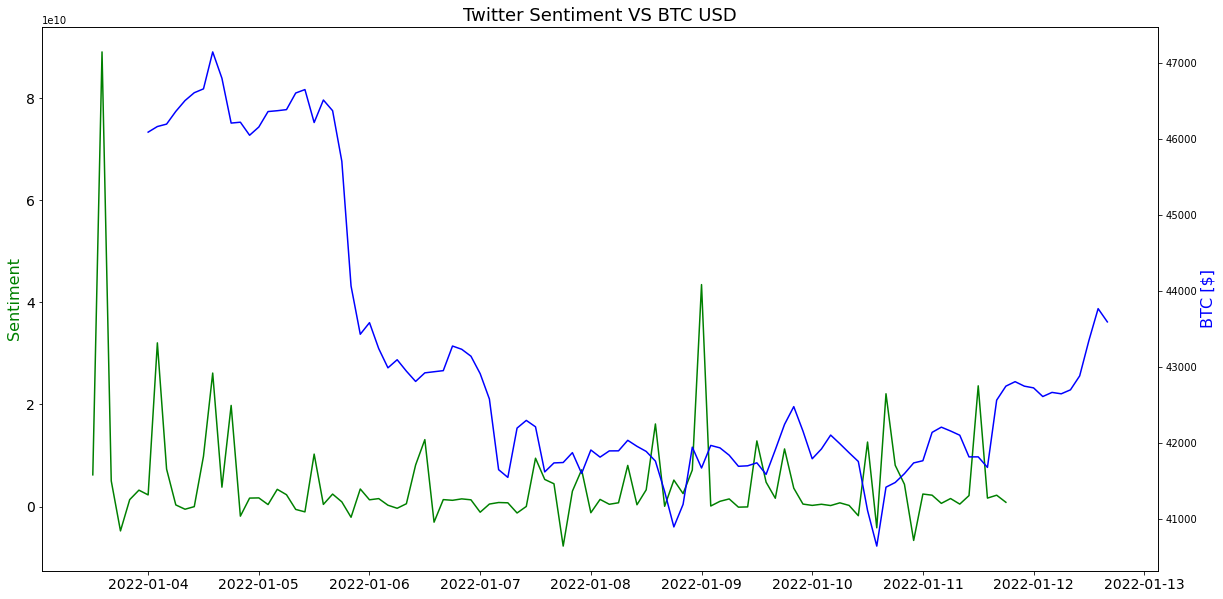

In [121]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(f"Twitter Sentiment VS {symbol} USD", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{symbol} [$]", color='b', fontsize=16)
plt.show()

In [122]:
# Cross correlation function declaration
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method="pearson")

In [123]:
beggining = max(tweets_grouped.index.min(), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max(), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

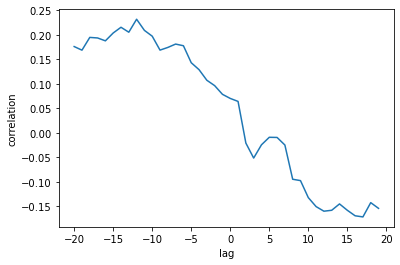

In [124]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

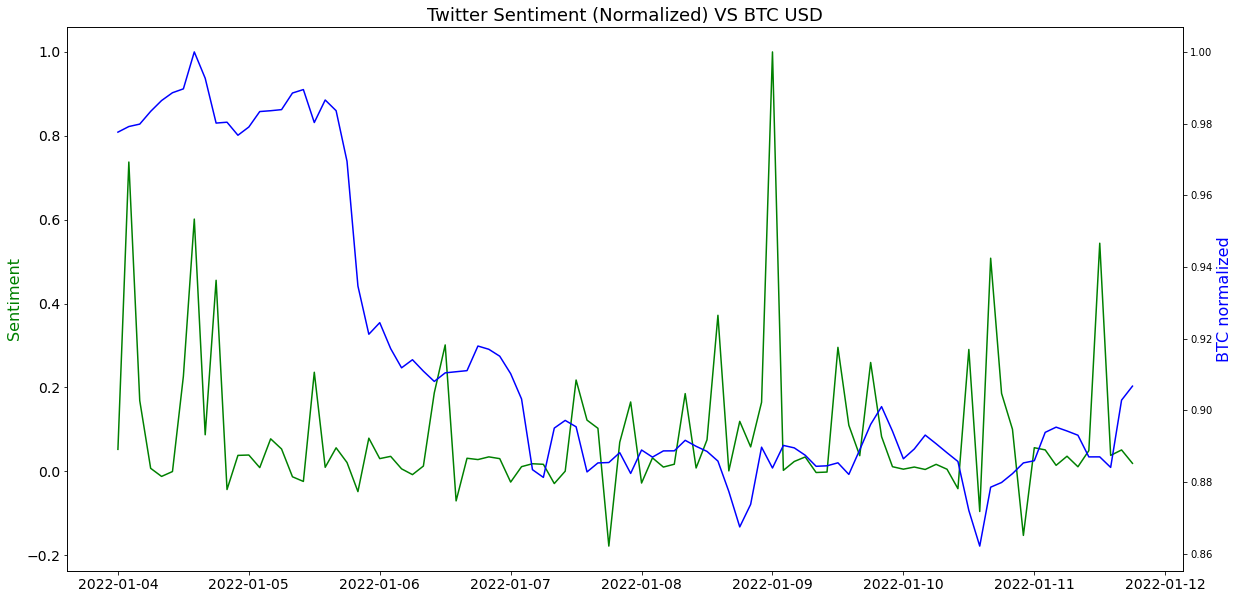

In [125]:
# Normalize all the data for the sentiment to be more meaningful for the crypto price
tweets_grouped = tweets_grouped / max(tweets_grouped.max(), abs(tweets_grouped.min()))
crypto_usd_grouped = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(f"Twitter Sentiment (Normalized) VS {symbol} USD", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{symbol} normalized", color='b', fontsize=16)
plt.show()

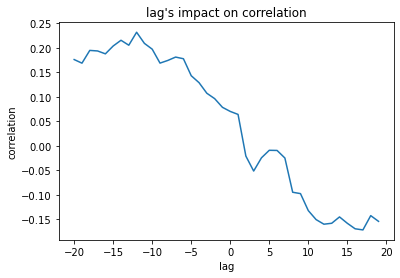

In [126]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [127]:
# Obtain the derivative
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

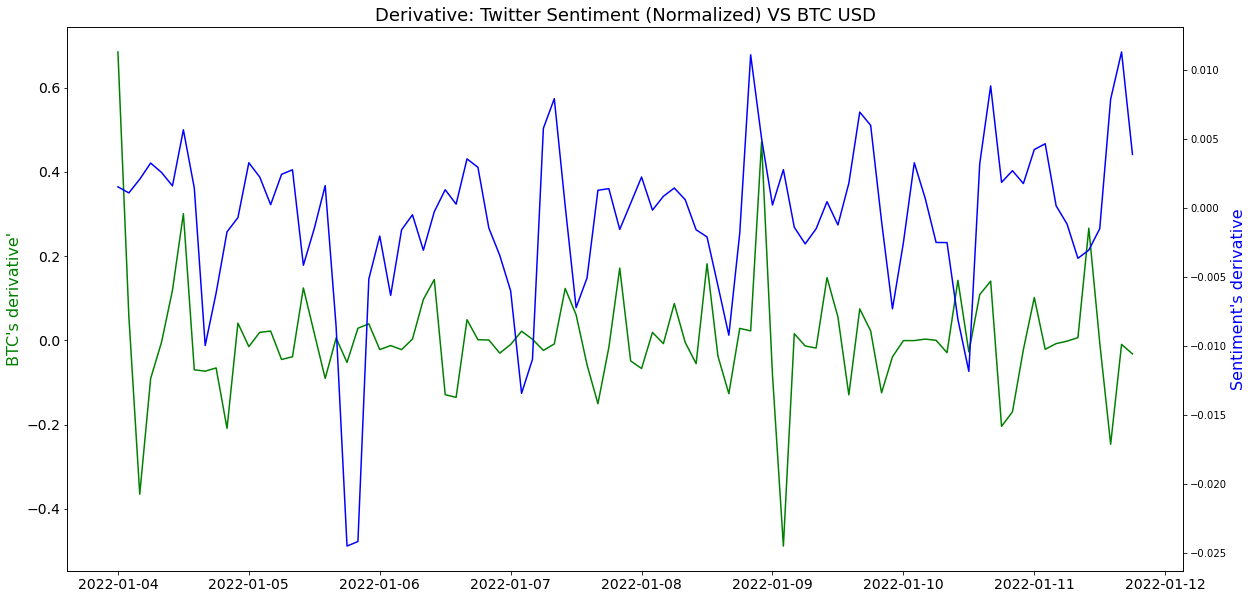

In [128]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(f"Derivative: Twitter Sentiment (Normalized) VS {symbol} USD", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel(f"{symbol}'s derivative'", color='g', fontsize=16)
ax2.set_ylabel("Sentiment's derivative", color='b', fontsize=16)
plt.show()

BTC
1642009500
2022-01-12 10:35:00
2022-01-12 10:45:00
(11, 7)
range= 2022-01-12 10:32:00 2022-01-12 10:45:00
2476
df_to_fulfill (14, 7)
df_remaining (0, 7)
done


/Users/aguerrero023/opt/anaconda3/envs/pyvizenv2/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



../data/crypto/BTC/2022-01-10 17-22-00~2022-01-12 10-45-00.csv
df shape (500, 7)
from 2022-01-12 02-29-00 to 2022-01-12 10-45-00


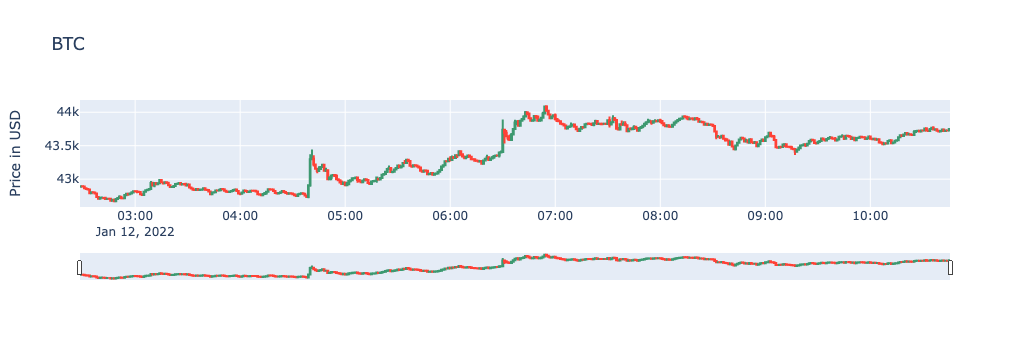

In [129]:
# Update data for crypto
file = open("current_crypto.txt", "w") 
file.write(symbol)
file.close()
%run antonio_crypto_data.ipynb